# KonzaPrairie Watershed

In [1]:
watershed = 'KonzaPrairie'

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# some_file.py
#import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')
#import Abnormal_data_values_control 
#from Abnormal_data_values_control import threC
import os
os.getcwd()
os.getcwd().rsplit('/',1)[0]

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/16-KonzaPrairie'

In [3]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed for this case
                'Precipitation':(0,9999), 
                'AirTemperature':(-20,50),
                'SolarRadiation':(-50,1361),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,101), 
                'SoilMoisture': (0,100),
                'SoilTemperature': (-5,50),  ### changed
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]    
    for i in range(len(prep.columns)):
        col = prep.columns[i]     
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])            
    return prep

### 1. Streamflow

In [4]:
linklist=['21','41','51','61']
names=['N04D','N20B','N01B','N02B']
df_lst1=[]
for i,number in enumerate(linklist):
    print(i)
    data=pd.read_csv('http://lter.konza.ksu.edu/sites/default/files/data/ASD0'+number+'.csv',
                        header = 0,parse_dates = True,
                         infer_datetime_format = True) 
    #print(data.columns)
    data.columns=[c.upper() for c in data.columns]
    data['DateTime']=pd.to_datetime([str(a)+'-'+str(b)+'-'+str(c) for a,b,c in zip(data['RECYEAR'],data['RECMONTH'],data['RECDAY'])],errors='coerce')
    data.index=data['DateTime']
    colname=[names[i]+'_Discharge']
    data=data[['DISCHARGE']]
    data.columns=colname
    #display(data.head(2))
    #display(data.tail(2))
    data=threC(data,'Discharge') 
    df_lst1.append(data)
dis1=aggre_and_comb_daily(df_lst1, axis=1, func = "mean") 


0
1
2
3
The final table is:


N04D_Discharge N20B_Discharge N01B_Discharge N02B_Discharge
1987-01-01            NaN              0            NaN              0
1987-01-02            NaN              0            NaN              0

N04D_Discharge N20B_Discharge N01B_Discharge N02B_Discharge
2019-12-30     0.00365972              0            NaN              0
2019-12-31          0.003              0            NaN              0

In [5]:
# unit is m3/s
linklist=['11','22','42','52','62']
df_lst2=[]
names=['KingsCreek','N04D','N20B','N01B','N02B']
for i,number in enumerate(linklist):
    print(i)
    if i==0:
        data=pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=06879650&referred_module=sw&period=&begin_date=1979-04-02&end_date=2019-12-31',
                        header = 0,parse_dates = True,skiprows=28,sep='\t',
                         infer_datetime_format = True)
        data = copy.deepcopy(data.drop([0]))
        data.index = data['datetime']
        data=data[['54911_00060_00003']] 
        data.index=pd.to_datetime(data.index)
        data.columns=['KingsRiver_Discharge']
    else:
        data=pd.read_csv('http://lter.konza.ksu.edu/sites/default/files/data/ASD0'+number+'.csv',
                        header = 0,parse_dates = True,
                         infer_datetime_format = True) 
        #print(data.columns)
        data.columns=[c.upper() for c in data.columns]
        data['DateTime']=pd.to_datetime([str(a)+'-'+str(b)+'-'+str(c) for a,b,c in zip(data['RECYEAR'],data['RECMONTH'],data['RECDAY'])],errors='coerce')
        data.index=data['DateTime']
        colname=[names[i]+'_Discharge']
        data=data[['MEANDISCHARGE']]
        data.columns=colname
    data=threC(data,'Discharge')   
    #display(data.head(2))
    #display(data.tail(2))
    df_lst2.append(data)
dis2=aggre_and_comb_daily(df_lst2, axis=1, func = "mean") 

0
1
2
3
4
The final table is:


KingsRiver_Discharge N04D_Discharge N20B_Discharge N01B_Discharge  \
1979-04-02                   13            NaN            NaN            NaN   
1979-04-03                   12            NaN            NaN            NaN   

           N02B_Discharge  
1979-04-02            NaN  
1979-04-03            NaN

KingsRiver_Discharge N04D_Discharge N20B_Discharge N01B_Discharge  \
2019-12-30                    0         0.0036              0         0.0004   
2019-12-31                    0         0.0031              0         0.0009   

           N02B_Discharge  
2019-12-30              0  
2019-12-31              0

In [6]:
prep=aggre_and_comb_daily([dis1,dis2], axis=0, func = "mean") 
prep.sort_index(inplace=True)
prep.head()

The final table is:


N04D_Discharge N20B_Discharge N01B_Discharge N02B_Discharge  \
DateTime                                                                 
1987-01-01            NaN              0            NaN              0   
1987-01-02            NaN              0            NaN              0   

           KingsRiver_Discharge  
DateTime                         
1987-01-01                  NaN  
1987-01-02                  NaN

N04D_Discharge N20B_Discharge N01B_Discharge N02B_Discharge  \
DateTime                                                                 
2019-12-30         0.0036              0         0.0004              0   
2019-12-31         0.0031              0         0.0009              0   

           KingsRiver_Discharge  
DateTime                         
2019-12-30                    0  
2019-12-31                    0

N04D_Discharge N20B_Discharge N01B_Discharge N02B_Discharge  \
DateTime                                                                 
1979-04-02            NaN            NaN            NaN            NaN   
1979-04-03            NaN            NaN            NaN            NaN   
1979-04-04            NaN            NaN            NaN            NaN   
1979-04-05            NaN            NaN            NaN            NaN   
1979-04-06            NaN            NaN            NaN            NaN   

           KingsRiver_Discharge  
DateTime                         
1979-04-02                   13  
1979-04-03                   12  
1979-04-04                   11  
1979-04-05                   11  
1979-04-06                   11

N04D_Discharge
N20B_Discharge
N01B_Discharge
N02B_Discharge
KingsRiver_Discharge


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

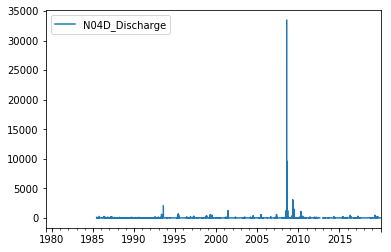

<Figure size 432x288 with 0 Axes>

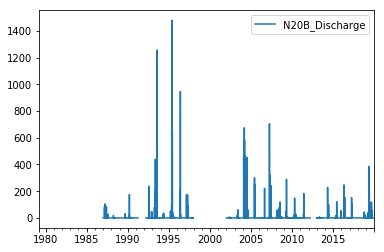

<Figure size 432x288 with 0 Axes>

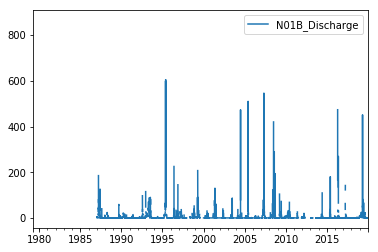

<Figure size 432x288 with 0 Axes>

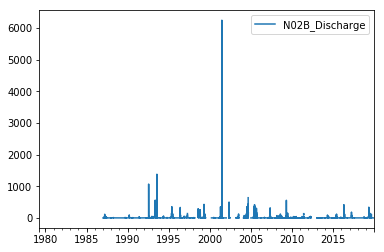

<Figure size 432x288 with 0 Axes>

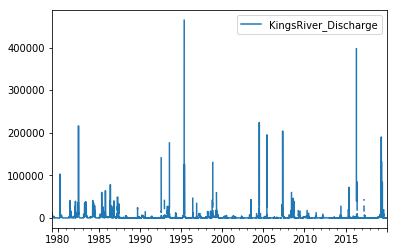

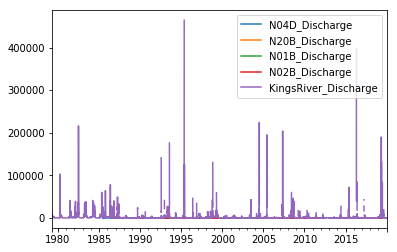

In [7]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Discharge unit should be L/s

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    if site=='KingsCreek_Discharge':
        for j in np.arange(len(prep)):  
            df.loc[tab.index[j]][ready_columns[i]] = tab[j]*28.3 # ft3/s to L/s
    else:
        for j in np.arange(len(prep)):  
            df.loc[tab.index[j]][ready_columns[i]] = tab[j]*1000 # m3/s to L/s
        
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'Discharge') 
Discharge = copy.deepcopy(df)
Discharge.plot()

### Hydrometeorology

### 2. Precipitation

In [8]:
# APT01 ppt station
data = pd.read_csv('http://lter.konza.ksu.edu/sites/default/files/data/APT011.csv',
                    header = 0,parse_dates = True,index_col = 'RecDate',infer_datetime_format = True)
data.head(5)

DataCode  RecType watershed   ppt Comments
RecDate                                              
1982-06-14    APT01        1        HQ    11      NaN
1982-06-15    APT01        1        HQ     8      NaN
1982-06-17    APT01        1        HQ     1      NaN
1982-06-21    APT01        1        HQ  12.5      NaN
1982-06-23    APT01        1        HQ  35.5      NaN

In [9]:
df_lst=[]
for site in data['watershed'].unique():
    df=data[data['watershed']==site][['ppt']]
    df.columns=[str(site)+'_Precipitation']
    df.index=pd.to_datetime(df.index)
    df=threC(df,'Precipitation')
    display(df.head(2))
    df_lst.append(df)
ppt1=aggre_and_comb_daily(df_lst, axis=1, func = "sum") 

HQ_Precipitation
RecDate                     
1982-06-14              11.0
1982-06-15               8.0

002C_Precipitation
RecDate                       
1983-04-01                28.9
1983-04-04                11.8

004B_Precipitation
RecDate                       
1983-04-01                30.7
1983-04-04                11.5

020B_Precipitation
RecDate                       
1983-04-01                32.0
1983-04-04                11.8

K01B_Precipitation
RecDate                       
1986-04-02                 4.0
1986-04-03                10.0

N01B_Precipitation
RecDate                       
1986-04-02                 4.0
1986-04-03                 8.5

N02B_Precipitation
RecDate                       
1986-04-02                 2.0
1986-04-03                10.5

N4DF_Precipitation
RecDate                       
1986-04-02                 3.5
1986-04-03                11.0

N4DU_Precipitation
RecDate                       
1986-04-02                 1.5
1986-04-03                 9.5

R01A_Precipitation
RecDate                       
1986-04-02                 0.5
1986-04-03                11.0

HQ02_Precipitation
RecDate                       
1986-08-20                13.0
1986-08-21                 1.0

The final table is:


HQ_Precipitation 002C_Precipitation 004B_Precipitation  \
1982-06-14               11                NaN                NaN   
1982-06-15                8                NaN                NaN   

           020B_Precipitation K01B_Precipitation N01B_Precipitation  \
1982-06-14                NaN                NaN                NaN   
1982-06-15                NaN                NaN                NaN   

           N02B_Precipitation N4DF_Precipitation N4DU_Precipitation  \
1982-06-14                NaN                NaN                NaN   
1982-06-15                NaN                NaN                NaN   

           R01A_Precipitation HQ02_Precipitation  
1982-06-14                NaN                NaN  
1982-06-15                NaN                NaN

HQ_Precipitation 002C_Precipitation 004B_Precipitation  \
2019-12-16              0.3                NaN                NaN   
2019-12-28             20.6                NaN                NaN   

           020B_Precipitation K01B_Precipitation N01B_Precipitation  \
2019-12-16                NaN                NaN                NaN   
2019-12-28                NaN                NaN                NaN   

           N02B_Precipitation N4DF_Precipitation N4DU_Precipitation  \
2019-12-16                NaN                NaN                NaN   
2019-12-28                NaN                NaN                NaN   

           R01A_Precipitation HQ02_Precipitation  
2019-12-16                NaN                NaN  
2019-12-28                NaN                NaN

In [13]:
df_lst[3]

020B_Precipitation
RecDate                       
1983-04-01                32.0
1983-04-04                11.8
1983-04-05                12.2
1983-04-08                 1.5
1983-04-09                 8.0
...                        ...
2019-10-18                 0.0
2019-10-19                 3.3
2019-10-20                19.3
2019-10-21                 0.0
2019-10-31                 0.9

[3182 rows x 1 columns]

In [14]:
# AWE01 met station
data12 = pd.read_csv('http://lter.konza.ksu.edu/sites/default/files/data/AWE012.csv',
                    header = 0)
data12['WATERSHED'] = data12['WATERSHED'].str.upper()
data12.head()

DATACODE  RECTYPE  RECYEAR  RECMONTH  RECDAY WATERSHED  DAYOFYEAR   TMAX  \
0    AWE01        2     1982         4      22      HQ01        112  22.28   
1    AWE01        2     1982         4      23      HQ01        113  22.23   
2    AWE01        2     1982         4      24      HQ01        114   18.7   
3    AWE01        2     1982         4      25      HQ01        115  21.89   
4    AWE01        2     1982         4      27      HQ01        117  15.47   

    TMIN   TAVE DHUMID  DSRAD DPPT SMAX SMIN S_AVE WAVE  
0  11.26  17.27  26.54  343.4    .    .    .     .    .  
1   9.57  14.94  44.59  489.1    .    .    .     .    .  
2  5.569  12.04  70.49  308.7    .    .    .     .    .  
3  4.367  13.49  53.62  626.2    .    .    .     .    .  
4  6.309  10.85  61.92  199.7    1    .    .     .    .

In [15]:
data12['DateTime']=pd.to_datetime([str(a)+'-'+str(b)+'-'+str(c) for a,b,c in zip(data12['RECYEAR'],data12['RECMONTH'],data12['RECDAY'])])
data12.index=data12['DateTime']
data12.head()

DATACODE  RECTYPE  RECYEAR  RECMONTH  RECDAY WATERSHED  DAYOFYEAR  \
DateTime                                                                       
1982-04-22    AWE01        2     1982         4      22      HQ01        112   
1982-04-23    AWE01        2     1982         4      23      HQ01        113   
1982-04-24    AWE01        2     1982         4      24      HQ01        114   
1982-04-25    AWE01        2     1982         4      25      HQ01        115   
1982-04-27    AWE01        2     1982         4      27      HQ01        117   

             TMAX   TMIN   TAVE DHUMID  DSRAD DPPT SMAX SMIN S_AVE WAVE  \
DateTime                                                                  
1982-04-22  22.28  11.26  17.27  26.54  343.4    .    .    .     .    .   
1982-04-23  22.23   9.57  14.94  44.59  489.1    .    .    .     .    .   
1982-04-24   18.7  5.569  12.04  70.49  308.7    .    .    .     .    .   
1982-04-25  21.89  4.367  13.49  53.62  626.2    .    .    .     .    .   
1982-04-27  15.47  6.309  10.85  61.92  199.7    1    .    .     .    .   

             DateTime  
DateTime               
1982-04-22 1982-04-22  
1982-04-23 1982-04-23  
1982-04-24 1982-04-24  
1982-04-25 1982-04-25  
1982-04-27 1982-04-27

In [16]:
ppt2=data12[['DPPT']]
ppt2=threC(ppt2,'Precipitation')
ppt2.columns=['HQ01_Precipitation']
ppt2=aggre_and_comb_daily([ppt2], axis=1, func = "sum") 

The final table is:


HQ01_Precipitation
1982-04-22                NaN
1982-04-23                NaN

HQ01_Precipitation
2019-12-30                  0
2019-12-31                  0

In [17]:
prep=aggre_and_comb_daily([ppt2], axis=1, func = "sum")  ###### not collecting ppt1 data

The final table is:


HQ01_Precipitation
1982-04-22                NaN
1982-04-23                NaN

HQ01_Precipitation
2019-12-30                  0
2019-12-31                  0

HQ01_Precipitation


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

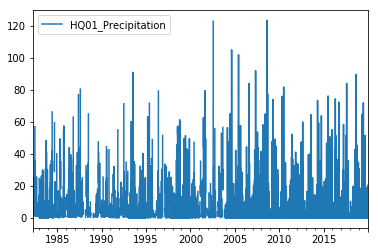

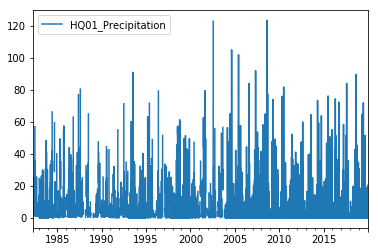

In [18]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Precipitation unit should be mm

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'Precipitation')     
Precipitation = copy.deepcopy(df)
Precipitation.plot()

### 3. Air Temperature

In [19]:
data12.head(2)

DATACODE  RECTYPE  RECYEAR  RECMONTH  RECDAY WATERSHED  DAYOFYEAR  \
DateTime                                                                       
1982-04-22    AWE01        2     1982         4      22      HQ01        112   
1982-04-23    AWE01        2     1982         4      23      HQ01        113   

             TMAX   TMIN   TAVE DHUMID  DSRAD DPPT SMAX SMIN S_AVE WAVE  \
DateTime                                                                  
1982-04-22  22.28  11.26  17.27  26.54  343.4    .    .    .     .    .   
1982-04-23  22.23   9.57  14.94  44.59  489.1    .    .    .     .    .   

             DateTime  
DateTime               
1982-04-22 1982-04-22  
1982-04-23 1982-04-23

In [20]:
data12.tail(2)

DATACODE  RECTYPE  RECYEAR  RECMONTH  RECDAY WATERSHED  DAYOFYEAR  \
DateTime                                                                       
2019-12-30    AWE01        2     2019        12      30      HQ01        364   
2019-12-31    AWE01        2     2019        12      31      HQ01        365   

             TMAX    TMIN   TAVE DHUMID  DSRAD DPPT   SMAX   SMIN  S_AVE  \
DateTime                                                                   
2019-12-30   2.92  -1.019  0.638  61.02  347.4    0  6.517  5.732  6.075   
2019-12-31  6.592  -3.052  0.582  58.25    982    0  5.733  5.205  5.395   

             WAVE   DateTime  
DateTime                      
2019-12-30  7.129 2019-12-30  
2019-12-31  3.768 2019-12-31

In [21]:
prep = copy.deepcopy(data12[['TAVE']])
prep = threC(prep,'AirTemperature')
prep.columns=['HQ01_AirTemperature']
prep.head()

HQ01_AirTemperature
DateTime                       
1982-04-22                17.27
1982-04-23                14.94
1982-04-24                12.04
1982-04-25                13.49
1982-04-27                10.85

In [22]:
# http://lter.konza.ksu.edu/sites/default/files/data11/AWE011.csv
# this is hourly data
data11 = pd.read_csv('http://lter.konza.ksu.edu/sites/default/files/data/AWE011.csv',
                    header = 0)
data11['WATERSHED'] = data11['WATERSHED'].str.upper()
data11['DateTime']=pd.to_datetime([str(a)+'-'+str(b)+'-'+str(c) for a,b,c in zip(data11['RECYEAR'],data11['RECMONTH'],data11['RECDAY'])])
data11.index=data11['DateTime']
data11.head()

DATACODE  RECTYPE  RECYEAR  RECMONTH  RECDAY WATERSHED  RECHOUR  \
DateTime                                                                     
1982-05-08    AWE01        1     1982         5       8      HQ01     1900   
1982-05-08    AWE01        1     1982         5       8      HQ01     2000   
1982-05-08    AWE01        1     1982         5       8      HQ01     2100   
1982-05-08    AWE01        1     1982         5       8      HQ01     2200   
1982-05-08    AWE01        1     1982         5       8      HQ01     2300   

             TAIR   RHUM WSPEED   WDIR    SRAD STEMP WMAX   DateTime  
DateTime                                                              
1982-05-08  24.25  38.13  5.031  180.3  33.723   NaN  NaN 1982-05-08  
1982-05-08  21.75  41.26   3.38  152.1   1.623   NaN  NaN 1982-05-08  
1982-05-08  18.81  52.03  2.269  173.2  -0.209   NaN  NaN 1982-05-08  
1982-05-08  18.06   58.4  3.187    163   -0.18   NaN  NaN 1982-05-08  
1982-05-08  17.34  60.75  3.828  188.4   -0.18   NaN  NaN 1982-05-08

HQ01_AirTemperature


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

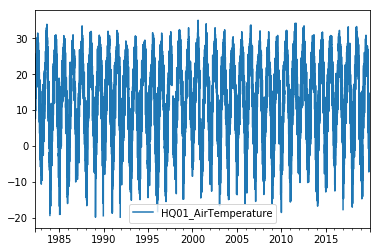

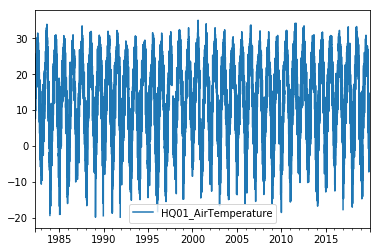

In [23]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! AirTemperature unit should be Degree celsius

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'AirTemperature')   
AirTemperature = copy.deepcopy(df)
AirTemperature.plot()

### 4. Solar Radiation

In [24]:
prep = copy.deepcopy(data12[['DSRAD']])
prep = threC(prep,'SolarRadiation')
prep.columns=['HQ01_SolarRadiation']

HQ01_SolarRadiation


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

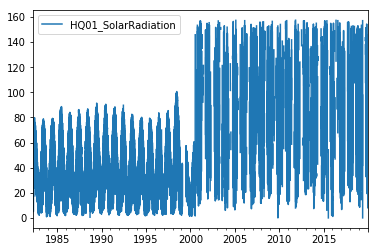

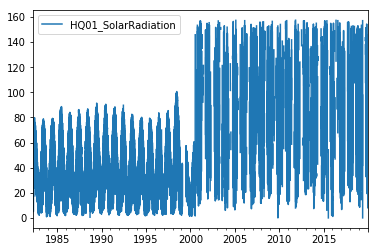

In [25]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SolarRadiation unit should be W/m2

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]/24/3600*10000  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'SolarRadiation')   
SolarRadiation = copy.deepcopy(df)
SolarRadiation.plot()

### 5. Relative Humidity

HQ01_RelativeHumidity


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

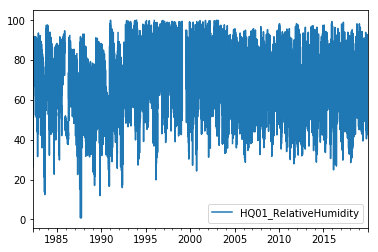

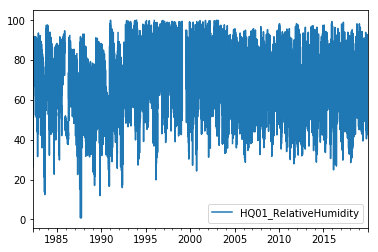

In [26]:
prep = copy.deepcopy(data12[['DHUMID']])
prep = threC(prep,'RelativeHumidity')
prep.columns=['HQ01_RelativeHumidity']

# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! RelativeHumidity unit should be %

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'RelativeHumidity')  
RelativeHumidity = copy.deepcopy(df)
RelativeHumidity.plot()

### 6. WindDirection

In [27]:
prep = copy.deepcopy(data11[['WDIR']])
prep = threC(prep,'WindDirection')
prep.columns=['HQ01_WindDirection']
prep = aggre_and_comb_daily([prep], axis=1, func = "mean")

['HQ01_WindDirection', datetime.date(1982, 11, 24)]
nan ratio is 0.08333333333333333 , groupby value is 193.5818181818182
['HQ01_WindDirection', datetime.date(1983, 12, 22)]
nan ratio is 0.041666666666666664 , groupby value is 304.70565217391305
['HQ01_WindDirection', datetime.date(1984, 1, 5)]
nan ratio is 0.08333333333333333 , groupby value is 237.65454545454543
['HQ01_WindDirection', datetime.date(1984, 1, 9)]
nan ratio is 0.08333333333333333 , groupby value is 119.86945454545456
['HQ01_WindDirection', datetime.date(1984, 1, 10)]
nan ratio is 0.08333333333333333 , groupby value is 105.7310909090909
['HQ01_WindDirection', datetime.date(1984, 1, 16)]
nan ratio is 0.041666666666666664 , groupby value is 159.47130434782608
['HQ01_WindDirection', datetime.date(1985, 4, 23)]
nan ratio is 0.041666666666666664 , groupby value is 251.46521739130438
['HQ01_WindDirection', datetime.date(1985, 7, 3)]
nan ratio is 0.041666666666666664 , groupby value is 192.22173913043477
['HQ01_WindDirection', 

['HQ01_WindDirection', datetime.date(1989, 12, 17)]
nan ratio is 0.041666666666666664 , groupby value is 169.1126521739131
['HQ01_WindDirection', datetime.date(1989, 12, 18)]
nan ratio is 0.041666666666666664 , groupby value is 95.20478260869565
['HQ01_WindDirection', datetime.date(1989, 12, 19)]
nan ratio is 0.08333333333333333 , groupby value is 238.4022727272727
['HQ01_WindDirection', datetime.date(1989, 12, 20)]
nan ratio is 0.041666666666666664 , groupby value is 112.44104347826088
['HQ01_WindDirection', datetime.date(1989, 12, 24)]
nan ratio is 0.041666666666666664 , groupby value is 233.37456521739134
['HQ01_WindDirection', datetime.date(1989, 12, 25)]
nan ratio is 0.041666666666666664 , groupby value is 273.90869565217383
['HQ01_WindDirection', datetime.date(1989, 12, 26)]
nan ratio is 0.08333333333333333 , groupby value is 108.32945454545455
['HQ01_WindDirection', datetime.date(1989, 12, 27)]
nan ratio is 0.08333333333333333 , groupby value is 216.05804545454546
['HQ01_WindDir

['HQ01_WindDirection', datetime.date(1991, 2, 13)]
nan ratio is 0.041666666666666664 , groupby value is 287.3626086956521
['HQ01_WindDirection', datetime.date(1991, 2, 28)]
nan ratio is 0.08333333333333333 , groupby value is 63.28518181818181
['HQ01_WindDirection', datetime.date(1991, 3, 4)]
nan ratio is 0.08333333333333333 , groupby value is 107.79590909090908
['HQ01_WindDirection', datetime.date(1991, 3, 20)]
nan ratio is 0.041666666666666664 , groupby value is 49.79621739130435
['HQ01_WindDirection', datetime.date(1991, 3, 21)]
nan ratio is 0.041666666666666664 , groupby value is 41.847130434782606
['HQ01_WindDirection', datetime.date(1991, 3, 28)]
nan ratio is 0.08333333333333333 , groupby value is 144.40795454545452
['HQ01_WindDirection', datetime.date(1991, 3, 30)]
nan ratio is 0.041666666666666664 , groupby value is 61.1201304347826
['HQ01_WindDirection', datetime.date(1991, 5, 5)]
nan ratio is 0.08333333333333333 , groupby value is 278.1122727272727
['HQ01_WindDirection', datet

['HQ01_WindDirection', datetime.date(2005, 10, 19)]
nan ratio is 0.041666666666666664 , groupby value is 88.26217391304348
['HQ01_WindDirection', datetime.date(2006, 11, 8)]
nan ratio is 0.041666666666666664 , groupby value is 204.9217391304348
['HQ01_WindDirection', datetime.date(2006, 11, 14)]
nan ratio is 0.041666666666666664 , groupby value is 120.85
['HQ01_WindDirection', datetime.date(2007, 12, 31)]
nan ratio is 0.041666666666666664 , groupby value is 283.47391304347826
['HQ01_WindDirection', datetime.date(2008, 12, 31)]
nan ratio is 0.041666666666666664 , groupby value is 163.39869565217393
['HQ01_WindDirection', datetime.date(2009, 4, 8)]
nan ratio is 0.08333333333333333 , groupby value is 133.47681818181817
['HQ01_WindDirection', datetime.date(2009, 12, 31)]
nan ratio is 0.041666666666666664 , groupby value is 209.1217391304348
['HQ01_WindDirection', datetime.date(2010, 12, 31)]
nan ratio is 0.041666666666666664 , groupby value is 207.63999999999996
['HQ01_WindDirection', date

HQ01_WindDirection
1982-04-22            219.214
1982-04-23            196.054

HQ01_WindDirection
2019-12-30            306.729
2019-12-31            260.421

HQ01_WindDirection


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

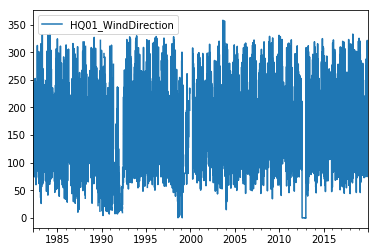

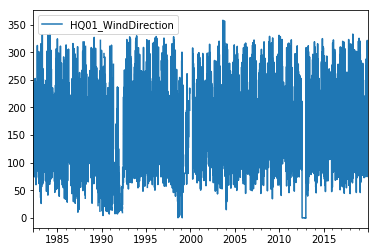

In [28]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! WindDirection unit should be degree

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'WindDirection')  
WindDirection = copy.deepcopy(df)
WindDirection.plot()

### 7. WindSpeed

HQ01_WindSpeed


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

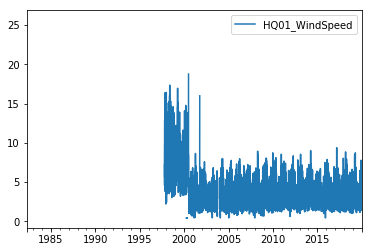

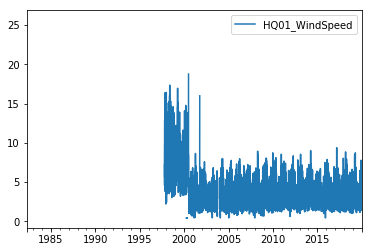

In [29]:
prep = copy.deepcopy(data12[['WAVE']])
prep = threC(prep,'WindSpeed')
prep.columns=['HQ01_WindSpeed']

# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! WindSpeed unit should be m/s

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'WindSpeed')  
WindSpeed = copy.deepcopy(df)
WindSpeed.plot()

In [30]:
# 8. SWE

In [31]:
# 9. SnowMelt

In [32]:
# 10. VaporPressure

In [33]:
# 11. SoilMoisture

In [34]:
### 12. SoilTemperature

HQ01_SoilTemperature


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

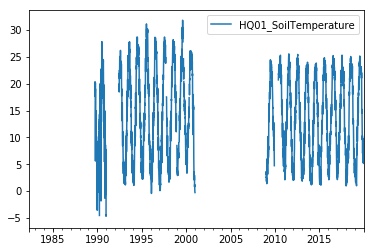

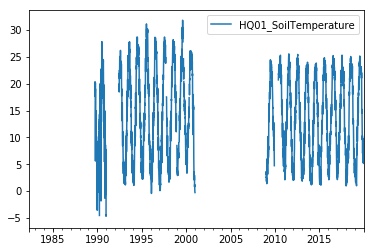

In [35]:
prep = copy.deepcopy(data12[['S_AVE']])
prep = threC(prep,'SoilTemperature')
prep.columns=['HQ01_SoilTemperature']

# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SoilTemperature unit should be degree celsius

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'SoilTemperature')  
SoilTemperature = copy.deepcopy(df)
SoilTemperature.plot()

# Results

In [36]:
# Put all the tables to the same date format
result = pd.concat([Discharge,Precipitation,AirTemperature,SolarRadiation,RelativeHumidity,
                     WindDirection,WindSpeed,SoilTemperature],
                    axis=1,
                    join='outer')



In [37]:
result.index.rename('DateTime', inplace = True)
result.head()

N04D_Discharge  N20B_Discharge  N01B_Discharge  N02B_Discharge  \
DateTime                                                                     
1979-04-02             NaN             NaN             NaN             NaN   
1979-04-03             NaN             NaN             NaN             NaN   
1979-04-04             NaN             NaN             NaN             NaN   
1979-04-05             NaN             NaN             NaN             NaN   
1979-04-06             NaN             NaN             NaN             NaN   

            KingsRiver_Discharge  HQ01_Precipitation  HQ01_AirTemperature  \
DateTime                                                                    
1979-04-02               13000.0                 NaN                  NaN   
1979-04-03               12000.0                 NaN                  NaN   
1979-04-04               11000.0                 NaN                  NaN   
1979-04-05               11000.0                 NaN                  NaN   
1979-04-06               11000.0                 NaN                  NaN   

            HQ01_SolarRadiation  HQ01_RelativeHumidity  HQ01_WindDirection  \
DateTime                                                                     
1979-04-02                  NaN                    NaN                 NaN   
1979-04-03                  NaN                    NaN                 NaN   
1979-04-04                  NaN                    NaN                 NaN   
1979-04-05                  NaN                    NaN                 NaN   
1979-04-06                  NaN                    NaN                 NaN   

            HQ01_WindSpeed  HQ01_SoilTemperature  
DateTime                                          
1979-04-02             NaN                   NaN  
1979-04-03             NaN                   NaN  
1979-04-04             NaN                   NaN  
1979-04-05             NaN                   NaN  
1979-04-06             NaN                   NaN

In [38]:
result.columns

Index(['N04D_Discharge', 'N20B_Discharge', 'N01B_Discharge', 'N02B_Discharge',
       'KingsRiver_Discharge', 'HQ01_Precipitation', 'HQ01_AirTemperature',
       'HQ01_SolarRadiation', 'HQ01_RelativeHumidity', 'HQ01_WindDirection',
       'HQ01_WindSpeed', 'HQ01_SoilTemperature'],
      dtype='object')

In [39]:
# Write data to csv for further inspection
result.to_csv('1_KonzaPrairie_Download_Aggregation_Daily.csv', sep=',')